# Bayes classificator and its behavior



## Learning goal

The learning goal of this notebook is to gain intuition on how classification problems work. We emphasize how important is to estimate the Bayes classifier for each problem and we do this in a setting that we can know the optimal classifier explicitly.  We will study the performance of this classifier as we change features of classes and the number of classes. The hope is that, with this in mind, we can understand how to increase the performance of classifiers in more general settings.

## Overview

As discussed in class, for any given classification problem it is essential to estimate the Bayes error rate, which dictates the best performance one can have at the specific problem. For example, it is easier to distinguish clear high-resolution images than to distinguish images taken with a camera made in 1970's. However, there's some samples from a given class that are inherently impossible to distinguish, no matter how good the classifier is (see image below). This is what we refer to when we talk about the Bayes error rate. Those samples will be inevitably misclassified.

Then, we'll first acquire some empirical knowledge by classifying samples from a binary Gaussian mixture model. After we are familiar with this problem, we'll reexamine the problem analytically. In the third section, we'll go even further and generalize the problem to  to develop intuition on what happens when samples are drawn from multi-class mixture model. In the final section we again go over analytical results and compare them with our experiments.

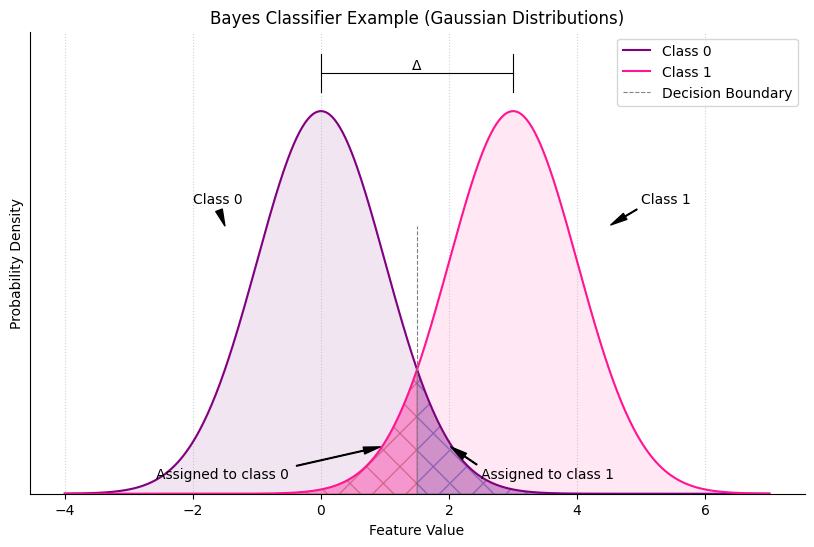

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define parameters for the two classes (means and standard deviations)
mu0 = 0  # Mean for Class 0
sigma0 = 1  # Standard deviation for Class 0

mu1 = 3  # Mean for Class 1
sigma1 = 1  # Standard deviation for Class 1

# Generate x values for the plot
x = np.linspace(-4, 7, 500)

# Calculate the probability density functions (PDFs) for each class
pdf0 = norm.pdf(x, mu0, sigma0)
pdf1 = norm.pdf(x, mu1, sigma1)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the PDF for Class 0
plt.plot(x, pdf0, label='Class 0', color='purple')
plt.fill_between(x, 0, pdf0, color='purple', alpha=0.1)

# Plot the PDF for Class 1
plt.plot(x, pdf1, label='Class 1', color='deeppink')
plt.fill_between(x, 0, pdf1, color='deeppink', alpha=0.1)

# Find the intersection point (decision boundary)
# For two normal distributions with equal variance, the decision boundary is exactly in the middle of the means.
# If variances are different, you'd solve norm.pdf(x, mu0, sigma0) = norm.pdf(x, mu1, sigma1)
decision_boundary = (mu0 + mu1) / 2
# --- MODIFIED PART ---
# Instead of axvline, we'll draw a plot line for the decision boundary
# Define the y-range for the decision boundary line
y_min_boundary = 0  # Start from the x-axis
y_max_boundary = np.max(pdf0) * 0.7 # Extend to 70% of the max PDF height (adjust as needed)

plt.plot([decision_boundary, decision_boundary], [y_min_boundary, y_max_boundary],
         color='gray', linestyle='--', linewidth=0.8, label='Decision Boundary')
# --- END MODIFIED PART ---


# Highlight the overlap region (misclassification region)
x_overlap = np.linspace(decision_boundary, x.max(), 100)
pdf0_overlap = norm.pdf(x_overlap, mu0, sigma0)
plt.fill_between(x_overlap, 0, pdf0_overlap, color='purple', alpha=0.3, hatch='x', edgecolor='darkblue', linewidth=0.5)

x_overlap_left = np.linspace(x.min(), decision_boundary, 100)
pdf1_overlap_left = norm.pdf(x_overlap_left, mu1, sigma1)
plt.fill_between(x_overlap_left, 0, pdf1_overlap_left, color='deeppink', alpha=0.3, hatch='x', edgecolor='darkred', linewidth=0.5)

# Add annotations from the image
plt.annotate('Class 1', xy=(mu1 + 1.5, norm.pdf(mu1, mu1, sigma1) * 0.7), xytext=(mu1 + 2, norm.pdf(mu1, mu1, sigma1) * 0.75),
             arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5),
             horizontalalignment='left', verticalalignment='bottom')

plt.annotate('Assigned to class 1', xy=(decision_boundary + 0.5, 0.05), xytext=(decision_boundary + 1, 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5),
             horizontalalignment='left', verticalalignment='center')

plt.annotate('Assigned to class 0', xy=(decision_boundary - 0.5, 0.05), xytext=(decision_boundary - 2, 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5),
             horizontalalignment='right', verticalalignment='center')

plt.annotate('Class 0', xy=(mu0 - 1.5, norm.pdf(mu0, mu0, sigma0) * 0.7), xytext=(mu0 - 2, norm.pdf(mu0, mu0, sigma0) * 0.75),
             arrowprops=dict(facecolor='black', shrink=0.5, width=0.5, headwidth=5),
             horizontalalignment='left', verticalalignment='bottom')

# Add the 'Δ' bracket (representing the separation or difference in means)
plt.plot([mu0, mu1], [norm.pdf(mu0, mu0, sigma0) * 1.1, norm.pdf(mu1, mu1, sigma1) * 1.1], color='black', linewidth=0.8)
plt.plot([mu0, mu0], [norm.pdf(mu0, mu0, sigma0) * 1.05, norm.pdf(mu0, mu0, sigma0) * 1.15], color='black', linewidth=0.8)
plt.plot([mu1, mu1], [norm.pdf(mu1, mu1, sigma1) * 1.05, norm.pdf(mu1, mu1, sigma1) * 1.15], color='black', linewidth=0.8)
plt.text((mu0 + mu1)/2, norm.pdf(mu0, mu0, sigma0) * 1.1, 'Δ', horizontalalignment='center', verticalalignment='bottom')


# Customize the plot
plt.title('Bayes Classifier Example (Gaussian Distributions)')
plt.xlabel('Feature Value')
plt.ylabel('Probability Density')
plt.yticks([]) # Remove y-axis ticks as in the original image
plt.ylim(bottom=0) # Ensure y-axis starts at 0

# Remove top and right spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
#plt.savefig('Bayes_classifier.png')
plt.show()

## Experiments with two classes

Consider a situation where we have a dataset where each data point is sampled from one of two Gaussians (see image above). The Gaussians are separated by a distance $\Delta$ and their variances are equal (assume this for simplicity for now). We want to understand how well we can classify this as a function of the ratio $\frac{\Delta}{\sigma}$ (which tells us what's the relationship between signal and noise).

The classifier we will use is simply the nearest-mean classifier. This uses the training set to compute what's the mean value of each class and then attributes each sample from the training set to the class that has the closest mean to it. For this problem, you can convince yourself that this is actually the best classifier that you can cook up.

Use the code below to plot accuracy as a function of the distance $\Delta$.

Sweeping Δ/σ ratios: 100%|██████████| 25/25 [00:00<00:00, 907.25it/s]


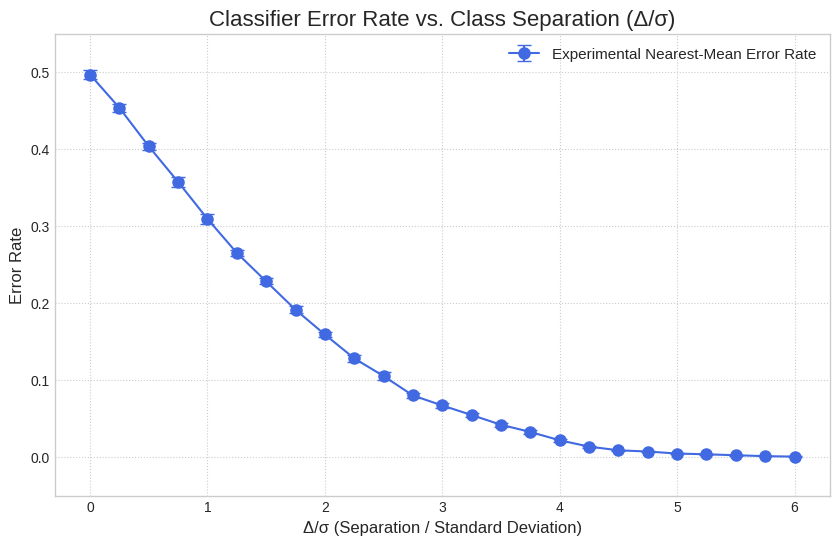

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

def experiment(delta, sigma, n_train=1000, n_test=500, seed=0):
    """Runs a single nearest-mean classification experiment and returns the error rate."""
    rng = np.random.default_rng(seed)

    # --- Generate Data ---
    # Class 0 centered at -delta/2, Class 1 centered at +delta/2
    X_train_0 = rng.normal(loc=-delta / 2, scale=sigma, size=(n_train // 2, 1))
    X_train_1 = rng.normal(loc=delta / 2, scale=sigma, size=(n_train // 2, 1))
    X_train = np.vstack([X_train_0, X_train_1])
    y_train = np.hstack([np.zeros(n_train // 2), np.ones(n_train // 2)])

    X_test_0 = rng.normal(loc=-delta / 2, scale=sigma, size=(n_test // 2, 1))
    X_test_1 = rng.normal(loc=delta / 2, scale=sigma, size=(n_test // 2, 1))
    X_test = np.vstack([X_test_0, X_test_1])
    y_test = np.hstack([np.zeros(n_test // 2), np.ones(n_test // 2)])

    # --- Nearest-Mean Classifier ---
    # 1. Training: Calculate the mean for each class
    centroid_0 = X_train[y_train == 0].mean()
    centroid_1 = X_train[y_train == 1].mean()

    # 2. Prediction: Assign test points to the class of the nearest centroid
    decision_boundary = (centroid_0 + centroid_1) / 2
    y_pred = (X_test > decision_boundary).flatten().astype(int)

    # Calculate accuracy and return the error rate
    accuracy = np.mean(y_pred == y_test)
    error_rate = 1.0 - accuracy
    return error_rate

def plot_error_vs_delta_sigma(delta_sigma_ratio_range, sigma, n_seeds, n_train, n_test):
    """Main function to run simulations and plot the error rate results."""

    experimental_errors = []
    experimental_std_errs = []
    theoretical_errs = []

    for ratio in tqdm(delta_sigma_ratio_range, desc="Sweeping Δ/σ ratios"):
        delta = ratio * sigma

        # Run multiple experiments for statistical significance
        scores = [experiment(delta, sigma, n_train, n_test, seed=s) for s in range(n_seeds)]
        mean_error = np.mean(scores)
        std_err = np.std(scores) / np.sqrt(n_seeds)

        experimental_errors.append(mean_error)
        experimental_std_errs.append(std_err)

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))

    # Plot experimental results with error bars
    plt.errorbar(delta_sigma_ratio_range, experimental_errors, yerr=experimental_std_errs, fmt='-o',
                 capsize=5, markersize=8, color='royalblue', label='Experimental Nearest-Mean Error Rate')


    plt.title('Classifier Error Rate vs. Class Separation (Δ/σ)', fontsize=16)
    plt.xlabel('Δ/σ (Separation / Standard Deviation)', fontsize=12)
    plt.ylabel('Error Rate', fontsize=12)
    plt.ylim(-0.05, 0.55)
    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle=':')
    plt.show()

# --- Run the Simulation ---
# Define the range of delta/sigma to test
delta_over_sigma_values = np.linspace(0, 6, 25)

plot_error_vs_delta_sigma(
    delta_sigma_ratio_range=delta_over_sigma_values,
    sigma=1.0,         # We can fix sigma=1.0 and vary delta to control the ratio
    n_seeds=5,         # Number of runs per data point for averaging
    n_train=2000,      # Number of training samples
    n_test=1000        # Number of testing samples
)



1.   Was that what you expected? Why at zero separation the error rate is 0.5 and not 1.0? Explain in your own words why this happens and what's the intuition behind it (look at the figure in the introduction, this should make sense).

2. $\textbf{Optional:}$ play around and use different variances for the Gaussians. Does this change the result? If yes, how?

## Some analytics

Now, let's derive the analytical result that explains this.

### Exercise: Deriving the Bayes Error Rate

**Problem Setup:**

Consider a one-dimensional classification problem with two classes, Class 0 ($C_0$) and Class 1 ($C_1$), which have equal prior probabilities, $P(C_0) = P(C_1) = 0.5$. The class-conditional probability densities are Gaussian distributions with the same standard deviation, $\sigma$.

- **Class 0:** $p(x|C_0) = \mathcal{N}(x | \mu_0, \sigma^2)$, where $\mu_0 = -\Delta/2$
- **Class 1:** $p(x|C_1) = \mathcal{N}(x | \mu_1, \sigma^2)$, where $\mu_1 = +\Delta/2$

Your task is to derive the formula for the minimum possible error rate, known as the Bayes error rate.

---

#### Step 1: Write Down the Probability Density Functions (PDFs) using the information given.

<!-- The PDFs for the two classes are given by the Gaussian formula:
$\mathcal{N}(x | \mu, \sigma^2) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left( - \frac{(x-\mu)^2}{2\sigma^2} \right)$.

Substituting the means for our classes:
$$ p(x|C_0) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left( - \frac{(x + \Delta/2)^2}{2\sigma^2} \right) $$
$$ p(x|C_1) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left( - \frac{(x - \Delta/2)^2}{2\sigma^2} \right) $$ -->

---

#### Step 2: Find the Optimal Decision Boundary

The optimal decision boundary, $x^*$, is where the posterior probabilities are equal. Since the priors are equal ($P(C_0) = P(C_1)$), this occurs where the likelihoods intersect: $p(x^*|C_0) = p(x^*|C_1)$. Show that $x^* = 0$.

---

#### Step 3: Define and Express the Error as an Integral

The Bayes error rate is the total probability of misclassification. Due to the symmetry of the problem, this is equal to the probability of misclassifying a sample from Class 0. A sample from Class 0 is misclassified if its value $x$ is greater than the decision boundary $x^*=0$.

<!-- $$ P(\text{error}) = \int_{x^*}^\infty p(x|C_0) dx = \int_{0}^\infty \frac{1}{\sigma\sqrt{2\pi}} \exp\left( - \frac{(x + \Delta/2)^2}{2\sigma^2} \right) dx $$ -->

---

#### Step 4: Solve the Integral via Change of Variables

We use a z-score transformation to standardize the variable. Let $z = \frac{x - \mu_0}{\sigma} = \frac{x + \Delta/2}{\sigma}$.

<!-- This implies $x = z\sigma - \Delta/2$ and $dx = \sigma dz$.

We must also transform the integration limit:
$$ \text{When } x = 0, \quad z = \frac{0 + \Delta/2}{\sigma} = \frac{\Delta}{2\sigma} $$
The integral becomes:
$$ P(\text{error}) = \int_{\Delta/(2\sigma)}^\infty \frac{1}{\sigma\sqrt{2\pi}} e^{-z^2/2} (\sigma dz) $$ -->

You should arrive at:
$$ P(\text{error}) = \int_{\Delta/(2\sigma)}^\infty \frac{1}{\sqrt{2\pi}} e^{-z^2/2} dz. $$
This integral is the definition of the complementary cumulative distribution function (CDF) of the standard normal distribution, often denoted as the Q-function, $Q(\Delta/(2\sigma))$. It is also equal to $1 - \Phi(\Delta/(2\sigma))$, where $\Phi(\Delta/(2\sigma))$ is the standard CDF.

---

### Final Result to Expect

After correctly completing all the steps, you should arrive at the following analytical result for the Bayes error rate:

$$ P(\text{error}) = 1 - \Phi\left(\frac{\Delta}{2\sigma}\right) $$

or equivalently, using the Q-function:

$$ P(\text{error}) = Q\left(\frac{\Delta}{2\sigma}\right) $$

---

Now, compare the theoretical result with the experiments that we performed.

Sweeping Δ/σ ratios: 100%|██████████| 25/25 [00:00<00:00, 771.68it/s]


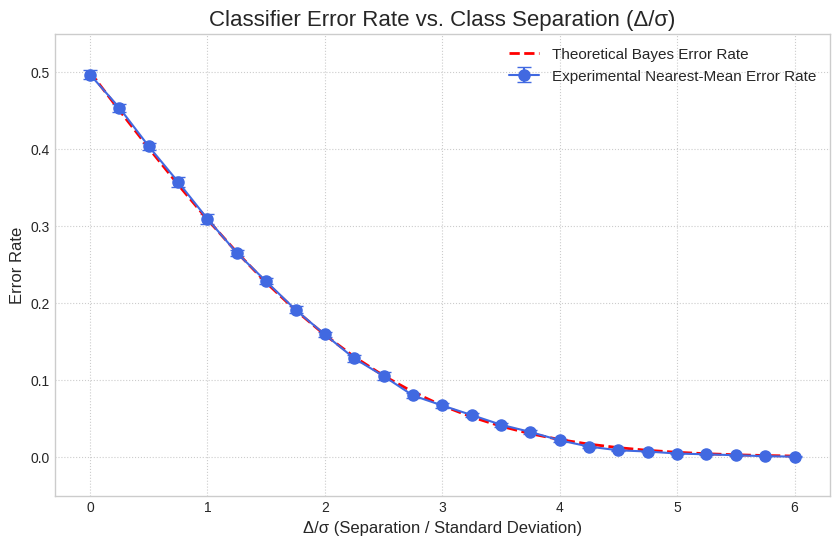

In [ ]:
def theoretical_error_rate(delta, sigma):
    """Calculates the theoretical minimum error rate (Bayes error) for two Gaussians."""
    # The Bayes error is the tail probability at the midpoint.
    return 1.0 - norm.cdf(delta / (2 * sigma))

def plot_error_vs_delta_sigma(delta_sigma_ratio_range, sigma, n_seeds, n_train, n_test):
    """Main function to run simulations and plot the error rate results."""

    experimental_errors = []
    experimental_std_errs = []
    theoretical_errs = []

    for ratio in tqdm(delta_sigma_ratio_range, desc="Sweeping Δ/σ ratios"):
        delta = ratio * sigma

        # Run multiple experiments for statistical significance
        scores = [experiment(delta, sigma, n_train, n_test, seed=s) for s in range(n_seeds)]
        mean_error = np.mean(scores)
        std_err = np.std(scores) / np.sqrt(n_seeds)

        experimental_errors.append(mean_error)
        experimental_std_errs.append(std_err)
        theoretical_errs.append(theoretical_error_rate(delta, sigma))

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))

    # Plot experimental results with error bars
    plt.errorbar(delta_sigma_ratio_range, experimental_errors, yerr=experimental_std_errs, fmt='-o',
                 capsize=5, markersize=8, color='royalblue', label='Experimental Nearest-Mean Error Rate')

    # Plot theoretical curve
    plt.plot(delta_sigma_ratio_range, theoretical_errs, '--', color='red',
             linewidth=2, label='Theoretical Bayes Error Rate')

    plt.title('Classifier Error Rate vs. Class Separation (Δ/σ)', fontsize=16)
    plt.xlabel('Δ/σ (Separation / Standard Deviation)', fontsize=12)
    plt.ylabel('Error Rate', fontsize=12)
    plt.ylim(-0.05, 0.55)
    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle=':')
    plt.show()

# --- Run the Simulation ---
# Define the range of delta/sigma to test
delta_over_sigma_values = np.linspace(0, 6, 25)

plot_error_vs_delta_sigma(
    delta_sigma_ratio_range=delta_over_sigma_values,
    sigma=1.0,         # We can fix sigma=1.0 and vary delta to control the ratio
    n_seeds=5,         # Number of runs per data point for averaging
    n_train=2000,      # Number of training samples
    n_test=1000        # Number of testing samples
)

## Beyond two Gaussians

Now, we propose the question: what if one has many Gaussians to classify, does this affect the behavior or should one expect the same error for the same $\frac{\Delta}{\sigma}$ we saw above?

**Problem setup**

Consider a $d$-dimensional classification problem with $C$ classes, Class 0 ($C_0$), Class 1 ($C_1$), ..., Class C ($C_C$), which have equal prior probabilities, $P(C_0) = P(C_1) = ... = P(C_C) = \frac{1}{C}$. The class-conditional probability densities are Gaussian distributions with the same standard deviation, $\sigma$.

- **Class 0:** $p(x|C_0) = \mathcal{N}(x | \mu_0, \sigma^2)$
- **Class 1:** $p(x|C_1) = \mathcal{N}(x | \mu_1, \sigma^2)$
- $\vdots$
- **Class C:** $p(x|C_C) = \mathcal{N}(x | \mu_C, \sigma^2)$

Where we consider that these classes live in a simplex (hence $C \leq d+1$), so
$$|\mu_i - \mu_j| = \Delta, \forall i,j.$$

## Experiments with $C$ Gaussians

Your job now is to play with the code below and build intuition on what's happening.

Sweeping C values: 100%|██████████| 6/6 [00:01<00:00,  4.09it/s]


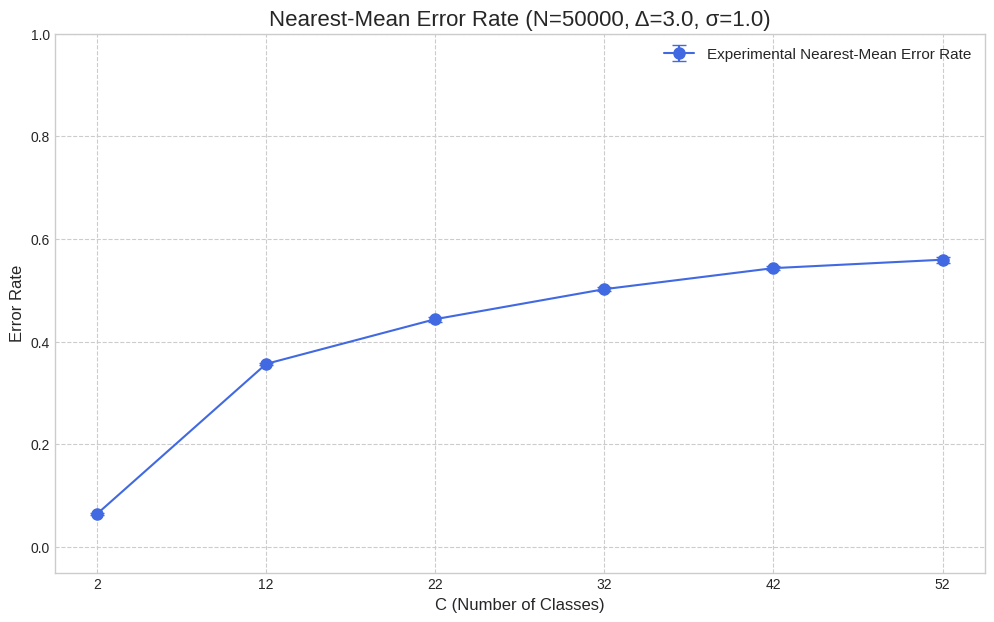

In [ ]:
import pandas as pd
from sklearn.metrics import f1_score

def make_simplex_means(C, d, Delta):
    if C > d + 1:
        raise ValueError("Cannot embed more than d+1 equidistant points in R^d.")
    V = np.eye(C) - np.ones((C, C)) / C
    V = V[:, :-1]
    norms = np.linalg.norm(V[0] - V[1])
    V = V / norms * Delta
    if d > V.shape[1]:
        V = np.hstack([V, np.zeros((C, d - V.shape[1]))])
    return V

def generate_data(N, C, d, Delta, sigma, rng):
    means = make_simplex_means(C, d, Delta)
    X, y = [], []
    n_per_class = max(1, N // C)
    for c in range(C):
        Xc = rng.normal(0, sigma, size=(n_per_class, d)) + means[c]
        yc = np.full(n_per_class, c)
        X.append(Xc)
        y.append(yc)
    return np.vstack(X), np.concatenate(y)

def experiment(C, N, d, Delta, sigma, n_test=200, seed=0):
    rng = np.random.default_rng(seed)
    X_train, y_train = generate_data(N, C, d, Delta, sigma, rng)
    X_test, y_test = generate_data(n_test, C, d, Delta, sigma, rng)

    unique_classes = np.unique(y_train)
    centroids = np.array([X_train[y_train == c].mean(axis=0) for c in unique_classes])
    sq_dists = np.sum((X_test[:, np.newaxis, :] - centroids[np.newaxis, :, :])**2, axis=2)
    y_pred = np.argmin(sq_dists, axis=1)

    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
    error_rate = 1 - f1
    return error_rate

def run_simulation_for_C(C, d, Delta, sigma, N, n_test, n_seeds):
    error_rates = [experiment(C=C, N=N, d=d, Delta=Delta, sigma=sigma,
                              n_test=n_test, seed=seed) for seed in range(n_seeds)]
    mean_error = np.mean(error_rates)
    std_err = np.std(error_rates) / np.sqrt(n_seeds)
    return mean_error, std_err

def plot_experimental_error(C_values, d, Delta, sigma, N, n_test, n_seeds):
    experimental_error_rates = []
    experimental_errors_std = []

    for C in tqdm(C_values, desc="Sweeping C values"):
        mean_error, std_err = run_simulation_for_C(C, d, Delta, sigma, N, n_test, n_seeds)
        experimental_error_rates.append(mean_error)
        experimental_errors_std.append(std_err)

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))

    plt.errorbar(C_values, experimental_error_rates, yerr=experimental_errors_std, fmt='-o',
                 capsize=5, markersize=8, color='royalblue', label='Experimental Nearest-Mean Error Rate')

    title = f'Nearest-Mean Error Rate (N={N}, Δ={Delta}, σ={sigma})'
    plt.title(title, fontsize=16)
    plt.xlabel('C (Number of Classes)', fontsize=12)
    plt.ylabel('Error Rate', fontsize=12)
    plt.xticks(C_values)
    plt.ylim(-0.05, 1.0)
    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle='--')
    plt.show()

# --- Run the Comparison ---
C_values_to_test = list(range(2, 53, 10))

plot_experimental_error(
    C_values=C_values_to_test,
    d=52,
    Delta=3.0,
    sigma=1.0,
    N=50000,
    n_test=2000,
    n_seeds=3
)

<b> Questions</b>

1. Does this behave as you first expected?  List item
2. Why does this happen?
3. Play with different values of $\Delta, N, \sigma, C, d$ and explain what's happening.

### Exercise: Deriving the Multi-Class Bayes Error Rate

**Problem Setup:**
We are analyzing a high-dimensional classification problem with $C$ classes. The data for each class $i$ is drawn from a Gaussian distribution, $p(x|C_i) = \mathcal{N}(x | \mu_i, \sigma^2\mathbb{I}_d)$. The means, $\mu_i$, are arranged in a regular simplex structure, meaning they are all equidistant from each other. Our goal is to derive the theoretical minimum error rate (the Bayes error rate) for this scenario.

---
#### Step 1: Define the Misclassification Condition
The optimal classifier for this problem is a **nearest-mean classifier**. A data point $x$ originally from Class 0 is misclassified if it is closer to the mean of any other class $j$ than it is to its own mean, $\mu_0$.

Let's define a variable $W_j$ that captures this comparison:
$$ W_j = ||x - \mu_j||^2 - ||x - \mu_0||^2 $$

What's the condition of misclassification?

<!--
A misclassification occurs if $W_j \le 0$ for any $j \neq 0$. Show that for a simplex centered at the origin (where $||\mu_i||^2$ is the same for all $i$), this simplifies to:
$$ W_j = 2x^T(\mu_0 - \mu_j) $$
 -->
---
#### Step 2: Incorporate the Data's Statistical Properties
A data point $x$ from Class 0 can be written as $x = \mu_0 + \epsilon$, where $\epsilon \sim \mathcal{N}(0, \sigma^2\mathbb{I}_d)$ is a random noise vector. Substitute this into the expression for $W_j$ and find the misclassification condition in terms of the data properties.

<!-- Using the geometric properties of a regular simplex, it can be shown that $2\mu_0^T(\mu_0 - \mu_j) = \Delta^2$, where $\Delta$ is the distance between any two class means. With this, show that the expression for $W_j$ becomes:
$$ W_j = \Delta^2 + 2\epsilon^T(\mu_0 - \mu_j) $$

From this, conclude that a misclassification occurs if:
$$ \epsilon^T(\mu_j - \mu_0) \ge \frac{\Delta^2}{2} $$ -->

---
#### Step 3: Standardize the Random Variables
Let's define a new set of random variables $Z_j = \epsilon^T(\mu_j - \mu_0)$ for $j=1, \dots, C-1$. These variables are normally distributed with a mean of 0 and a variance of $\sigma^2\Delta^2$.

To simplify the math, we standardize these variables. Define $Y_j = \frac{Z_j}{\sigma\Delta}$. What are the mean, variance, and covariance of these new variables, $Y_j$?

---
#### Step 4: Decompose the Correlated Variables
The variables $Y_j$ are correlated. We can represent them as a sum of independent standard normal variables, $S$ and $V_j$, to handle this correlation:
$$ Y_j = \frac{S + V_j}{\sqrt{2}} $$
where $S \sim \mathcal{N}(0,1)$ and all $V_j \sim \mathcal{N}(0,1)$ are independent.

A point is classified correctly if $W_j > 0$ for all $j \neq 0$, which is equivalent to $Y_j \le t$, where $t = \frac{\Delta}{2\sigma}$. The probability of a correct classification is therefore $P_{\text{correct}} = P(\forall j: Y_j \le t)$.

---
#### Step 5: Derive the Final Integral
To find the total probability of a correct classification, we must average over all possible values of the shared variable $S$. This is done by conditioning on $S=s$ and then integrating over the distribution of $s$.

1.  Given a fixed value $S=s$, what is the probability that a single $Y_j \le t$? Show that this is equal to $\Phi(\sqrt{2}t - s)$, where $\Phi$ is the CDF of the standard normal distribution.
2.  Since all the $V_j$ are independent, what is the probability that *all* $Y_j \le t$ for $j=1, \dots, C-1$, conditioned on $S=s$?
3.  Finally, write the integral that averages this conditional probability over all possible values of $s$, weighted by the probability density of $s$ (which is $\phi(s)$, the PDF of a standard normal distribution).

This will give you the final expression for the probability of a correct classification. The Bayes error is simply $1 - P_{\text{correct}}$.

### Final Result to Expect
After completing the steps, you should arrive at the following integral for the probability of a correct classification:
$$ P_{\text{correct}} = \int_{-\infty}^{\infty} \phi(s) \left[ \Phi(\sqrt{2}t - s) \right]^{C-1} ds $$
where $t=\frac{\Delta}{2\sigma}$, $\phi(s)$ is the PDF of the standard normal distribution, and $\Phi(s)$ is its CDF.

Sweeping C values: 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


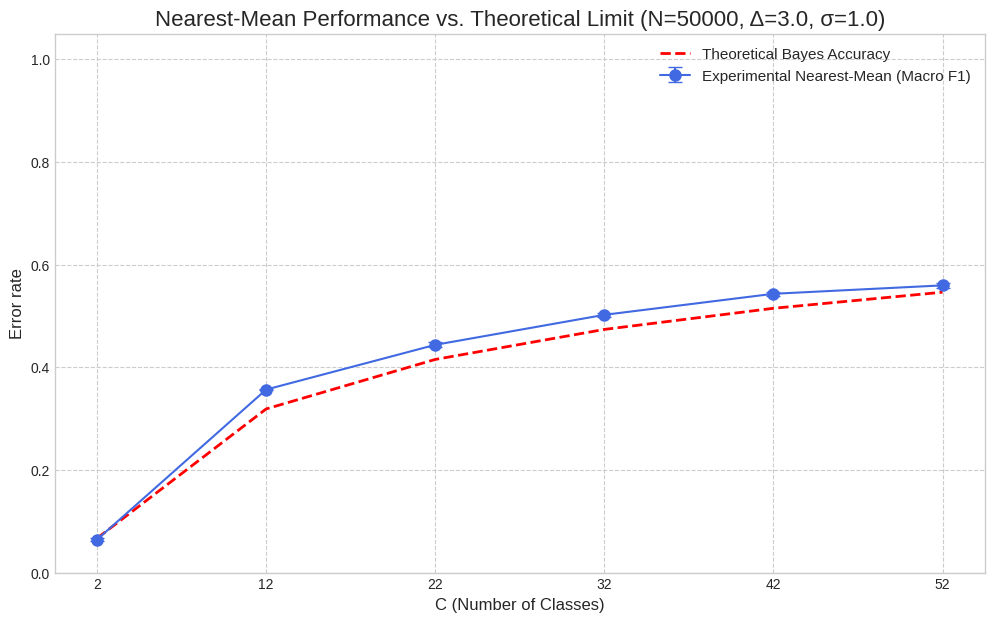

In [ ]:
from scipy.stats import norm
from scipy.integrate import quad

def bayes_error(C, Delta, sigma):
    """Calculates the theoretical minimum error rate for the simplex data model."""
    t = Delta / (2 * sigma)
    m = C - 1
    def integrand(s):
        return norm.pdf(s) * norm.cdf(np.sqrt(2) * t - s)**m
    val, _ = quad(integrand, -np.inf, np.inf)
    return 1 - val

def plot_experimental_vs_theoretical(C_values, d, Delta, sigma, N, n_test, n_seeds):
    experimental_f1_scores = []
    experimental_errors = []
    theoretical_accuracies = []

    for C in tqdm(C_values, desc="Sweeping C values"):
        mean_f1, std_err = run_simulation_for_C(C, d, Delta, sigma, N, n_test, n_seeds)
        experimental_f1_scores.append(mean_f1)
        experimental_errors.append(std_err)
        theoretical_accuracies.append(bayes_error(C, Delta, sigma))

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))

    plt.errorbar(C_values, experimental_f1_scores, yerr=experimental_errors, fmt='-o',
                 capsize=5, markersize=8, color='royalblue', label='Experimental Nearest-Mean (Macro F1)')
    plt.plot(C_values, theoretical_accuracies, '--', color='red', linewidth=2, label='Theoretical Bayes Accuracy')

    title = f'Nearest-Mean Performance vs. Theoretical Limit (N={N}, Δ={Delta}, σ={sigma})'
    plt.title(title, fontsize=16)
    plt.xlabel('C (Number of Classes)', fontsize=12)
    plt.ylabel('Error rate', fontsize=12)
    plt.xticks(C_values)
    plt.ylim(0, 1.05)
    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle='--')
    plt.show()

# --- Run the Comparison ---
# Note: d must be >= C-1. Here d=102, so C can be up to 103.
C_values_to_test = list(range(2, 53, 10))

plot_experimental_vs_theoretical(
    C_values=C_values_to_test,
    d=52,
    Delta=3.0,
    sigma=1.0,
    N=50000,
    n_test=2000,
    n_seeds=3
)